In [1]:
import pandas as pd
import numpy as np

df = pd.read_table('~/Downloads/INFO_4604/AwarenessVsInfection_month.tsv')

new_df = df.loc[:,['Twitter_content','intent']]
df2 = new_df.rename(index=str, columns={"Twitter_content": "Text", "intent": "Illness"})

df2.head()

,Text,Illness
0,you gotta be kidding me .. everyone around me ...,0
1,getting my flu shot then babysitting .,1
2,my arm is getting sore from that damn flu shot...,1
3,seems like these bird profile pics are spreadi...,1
4,i think i'm in the process of getting the flu ...,0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

text_train, text_test, Y_train, Y_test = train_test_split(df2['Text'], df2['Illness'], test_size=0.4, random_state=0)

In [3]:
import re
from collections import Counter

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def skipgrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        str1 = ''
        for j in range(n-2):
            str1 = str1+' * '
        skipgram = str(tokens[i-n+1])+str1+str(tokens[i])
        output.append(skipgram)
    return output

import itertools

def pairs(words):
    ret = itertools.combinations(words,2)
    return ret
   
def features(text, ngram_range=(1,3)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
        #remove sentiment
    
    for n in range(3,5):
        features_in_text += skipgrams(text_alphanum.split(), n)
      
    features_in_text += str(pairs(text_alphanum.split()))
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
   
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return Counter(features_in_text)

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

vect = DictVectorizer()
X_train = vect.fit_transform(features(d, ngram_range=(1,3)) for d in text_train)

In [5]:
from urllib.request import urlopen
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score

X_test = vect.transform(features(d, ngram_range=(1,3)) for d in text_test)

classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123)
classifier.fit(X_train, Y_train)

print("No Averaging")
print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
    
classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_train, Y_train)

print("Averaging")
print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
feature_names = np.asarray(vect.get_feature_names())
args = np.argsort(classifier.coef_[0])
for a in args:
    print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

No Averaging
Number of SGD iterations: 9
Training accuracy: 0.998471
Testing accuracy: 0.786697
Averaging
Number of SGD iterations: 9
Training accuracy: 0.987768
Testing accuracy: 0.795872

Feature weights:
 getting: -57.6001
 better: -47.1897
 has: -44.2075
 getting over: -37.9362
 the flu: -31.5944
 getting better: -31.0847
 got: -28.2823
 over: -26.9277
 :(: -26.9227
 feel: -26.8123
 sick: -25.9952
 have: -25.9307
 hope: -25.3880
 and: -25.0494
 well: -24.8208
 im: -24.1265
 over * flu: -22.0991
 have the: -21.8377
 i: -21.3335
 ..: -20.9668
 getting over the: -20.7532
 fever: -20.4541
 feeling: -20.2867
 have * flu: -20.2437
 it: -20.1552
 he: -18.8789
 with: -18.8282
 9: -18.8163
 getting swine flu: -18.7693
 getting swine: -18.7693
 getting *  * flu: -18.5550
 over the: -18.4389
 no: -18.2649
 day: -17.8901
 getting * the: -17.7559
 might: -17.5786
 c: -17.4502
 soon: -17.0591
 or: -16.8435
 i * getting: -15.6217
 p: -15.2298
 e: -15.1773
 fine: -14.8691
 sucks: -14.8164
 bed: -1

 ryo: -3.6666
 soon yamap: -3.6666
 soon yamap ryo: -3.6666
 worse * well: -3.6666
 get *  * yamap: -3.6666
 yamap ryo: -3.6666
 sniffle: -3.6610
 is *  * sniffle: -3.6610
 my self: -3.6610
 if it s: -3.6608
 if * s: -3.6608
 to *  * my: -3.6594
 i * got: -3.6491
 user *  * but: -3.6460
 you *  * that: -3.6459
 just * for: -3.6437
 sick with: -3.6426
 thought *  * the: -3.6409
 thinks * might: -3.6348
 swine * soon: -3.6310
 flu soon: -3.6310
 swine flu soon: -3.6310
 this morning: -3.6295
 got * for: -3.6288
 be * over: -3.6224
 be getting over: -3.6224
 to *  * over: -3.6224
 oink: -3.6213
 the *  * to: -3.6211
 now * and: -3.6206
 today but: -3.6191
 so * on: -3.6178
 user lucky on: -3.6178
 lucky *  * clothing: -3.6178
 lunch more bird: -3.6178
 believe *  * so: -3.6178
 s * lucky: -3.6178
 lunch more: -3.6178
 more bird flu: -3.6178
 s so lucky: -3.6178
 flu y: -3.6178
 so lucky: -3.6178
 so lucky on: -3.6178
 the lunch more: -3.6178
 the clothing: -3.6178
 lucky *  * lunch: -3.61

 and everything: -3.0292
 caught * in: -3.0292
 year *  * it: -3.0292
 europe used my: -3.0292
 t be so: -3.0292
 caught *  * europe: -3.0292
 so afraid of: -3.0292
 t *  * afraid: -3.0292
 my germ: -3.0292
 germ blaster: -3.0292
 germ *  * germ: -3.0292
 used my germ: -3.0292
 this *  * caught: -3.0292
 everything * fine: -3.0292
 it *  * used: -3.0292
 was fine: -3.0292
 blaster: -3.0292
 blaster *  * shield: -3.0292
 blaster * germ: -3.0292
 everything was: -3.0292
 year i caught: -3.0292
 everything was fine: -3.0292
 it in europe: -3.0292
 be so afraid: -3.0292
 it in: -3.0292
 blaster and: -3.0292
 blaster and germ: -3.0292
 don *  * so: -3.0292
 t * so: -3.0292
 in europe used: -3.0292
 my *  * and: -3.0292
 don t be: -3.0292
 germ *  * everything: -3.0292
 and *  * fine: -3.0292
 used my: -3.0292
 and * was: -3.0292
 year * caught: -3.0292
 and germ shield: -3.0292
 shield and everything: -3.0292
 and * shield: -3.0292
 in * used: -3.0292
 as * dog: -3.0287
 airport i fear: -3.

 feel *  * ugh: -2.6972
 feel * sick: -2.6972
 ugh getting the: -2.6972
 ugh * the: -2.6972
 feel soo: -2.6972
 ugh getting: -2.6972
 i feel soo: -2.6972
 sick ugh: -2.6972
 sick ugh getting: -2.6972
 has *  * scared: -2.6926
 first *  * getting: -2.6922
 since getting: -2.6922
 first * since: -2.6922
 i *  * tired: -2.6914
 hashtag getting the: -2.6902
 sick coworkers dropping: -2.6902
 flies hashtag: -2.6902
 and kids: -2.6902
 and kids on: -2.6902
 and *  * friday: -2.6902
 me and kids: -2.6902
 flies hashtag getting: -2.6902
 dropping * flies: -2.6902
 coworkers * like: -2.6902
 shot for me: -2.6902
 dropping *  * hashtag: -2.6902
 dropping: -2.6902
 dropping like: -2.6902
 me *  * on: -2.6902
 dropping like flies: -2.6902
 kids * friday: -2.6902
 like flies: -2.6902
 like * hashtag: -2.6902
 like flies hashtag: -2.6902
 kids on: -2.6902
 flies * getting: -2.6902
 kids on friday: -2.6902
 sick * dropping: -2.6902
 coworkers dropping like: -2.6902
 coworkers dropping: -2.6902
 sick 

 flu after: -2.3230
 swine *  * my: -2.3219
 hav: -2.3200
 hand *  * coughing: -2.3185
 hand sanitizer dratted: -2.3185
 before * w: -2.3185
 hand * dratted: -2.3185
 the *  * wasn: -2.3185
 a smart idea: -2.3185
 flu *  * vacation: -2.3185
 thinking riding: -2.3185
 thinking * the: -2.3185
 the bus home: -2.3185
 in * season: -2.3185
 before vacation w: -2.3185
 sanitizer dratted: -2.3185
 sanitizer * coughing: -2.3185
 before vacation: -2.3185
 sanitizer *  * kid: -2.3185
 a smart: -2.3185
 thinking riding the: -2.3185
 thinking *  * bus: -2.3185
 idea in flu: -2.3185
 vacation w: -2.3185
 coughing * hashtag: -2.3185
 t a smart: -2.3185
 t * smart: -2.3185
 w o: -2.3185
 w o hand: -2.3185
 t *  * idea: -2.3185
 dratted coughing kid: -2.3185
 dratted coughing: -2.3185
 dratted * kid: -2.3185
 dratted *  * hashtag: -2.3185
 dratted: -2.3185
 home * t: -2.3185
 home wasn: -2.3185
 home wasn t: -2.3185
 m thinking riding: -2.3185
 coughing kid: -2.3185
 vacation w o: -2.3185
 coughing ki

 feeling poorly haven: -2.1276
 worked since friday: -2.1276
 as just came: -2.1276
 still *  * haven: -2.1276
 worked *  * got: -2.1276
 from * but: -2.1276
 feeling * haven: -2.1276
 from usa but: -2.1276
 poorly *  * worked: -2.1276
 t *  * friday: -2.1276
 poorly * t: -2.1276
 poorly haven: -2.1276
 back *  * but: -2.1276
 but sure: -2.1276
 was *  * worried: -2.1276
 but sure it: -2.1276
 bit * as: -2.1276
 t worked since: -2.1276
 t worked: -2.1276
 was * bit: -2.1276
 since friday got: -2.1276
 got *  * was: -2.1276
 still * poorly: -2.1276
 bit *  * just: -2.1276
 as just: -2.1276
 the flu was: -2.1276
 was a bit: -2.1276
 worried as just: -2.1276
 flu was a: -2.1276
 from usa: -2.1276
 usa: -2.1276
 t * since: -2.1276
 since *  * the: -2.1276
 but *  * s: -2.1276
 a *  * as: -2.1276
 since friday: -2.1276
 as * came: -2.1276
 feeling poorly: -2.1276
 bit worried as: -2.1276
 little * who: -2.1269
 nasty: -2.1251
 nasty flu: -2.1251
 anxious: -2.1247
 of my: -2.1237
 user just 

 general * with: -2.0536
 more working and: -2.0536
 the *  * working: -2.0536
 flu recovering from: -2.0536
 not much working: -2.0536
 and general madness: -2.0536
 not much: -2.0536
 and general: -2.0536
 much working: -2.0536
 working * general: -2.0536
 much working getting: -2.0536
 more working: -2.0536
 the * recovering: -2.0536
 madness * friends: -2.0536
 more *  * general: -2.0536
 flu recovering: -2.0536
 general madness: -2.0536
 from *  * more: -2.0536
 general madness with: -2.0536
 getting *  * recovering: -2.0536
 the flu more: -2.0536
 general *  * friends: -2.0536
 and * madness: -2.0536
 with friends: -2.0536
 working getting the: -2.0536
 recovering * the: -2.0536
 user *  * working: -2.0536
 user * much: -2.0536
 flu more working: -2.0536
 working *  * flu: -2.0536
 general: -2.0536
 not * working: -2.0536
 working *  * madness: -2.0536
 flu * from: -2.0536
 a joke: -2.0525
 bit * when: -2.0519
 at * concert: -2.0514
 pooh *  * i: -2.0514
 user *  * get: -2.0514
 

 i m wrong: -1.9067
 determined: -1.9067
 determined i: -1.9067
 throat * determined: -1.9067
 and *  * feeling: -1.9064
 not sure: -1.9056
 a * followed: -1.9054
 way *  * was: -1.9054
 week * by: -1.9054
 getting * work: -1.9054
 getting sacked work: -1.9054
 wasted for a: -1.9054
 week followed: -1.9054
 a *  * by: -1.9054
 user got the: -1.9054
 wasted for: -1.9054
 user got: -1.9054
 getting sacked: -1.9054
 wasted * a: -1.9054
 was wasted for: -1.9054
 8 devs: -1.9054
 week followed by: -1.9054
 8 * getting: -1.9054
 wasted *  * week: -1.9054
 wasted: -1.9054
 8 devs getting: -1.9054
 8 *  * sacked: -1.9054
 by * devs: -1.9054
 home so was: -1.9054
 sacked work: -1.9054
 was * for: -1.9054
 so was wasted: -1.9054
 way * so: -1.9054
 so * wasted: -1.9054
 way home so: -1.9054
 followed by 8: -1.9054
 followed by: -1.9054
 followed * 8: -1.9054
 sacked * hashtag: -1.9054
 way home: -1.9054
 followed *  * devs: -1.9054
 followed: -1.9054
 by 8: -1.9054
 got *  * on: -1.9054
 so was:

 and relatives: -1.8151
 has contracted a: -1.8151
 wedding * brother: -1.8151
 and relatives fear: -1.8151
 batshittiness *  * t: -1.8151
 t * 7: -1.8151
 t minus: -1.8151
 t minus 7: -1.8151
 t *  * hours: -1.8151
 relatives: -1.8151
 relatives *  * squee: -1.8151
 relatives * swine: -1.8151
 before *  * my: -1.8151
 relatives fear: -1.8151
 the wedding my: -1.8151
 the wedding: -1.8151
 my brother has: -1.8151
 batshittiness has begun: -1.8151
 batshittiness has: -1.8151
 batshittiness: -1.8151
 relatives fear swine: -1.8151
 minus 7: -1.8151
 my *  * contracted: -1.8151
 contracted: -1.8151
 minus * hours: -1.8151
 flu and relatives: -1.8151
 minus *  * before: -1.8151
 minus: -1.8151
 7 *  * the: -1.8151
 wedding my brother: -1.8151
 and * fear: -1.8151
 contracted a flu: -1.8151
 7 hours: -1.8151
 batshittiness * begun: -1.8151
 flu * relatives: -1.8151
 contracted * flu: -1.8151
 contracted *  * and: -1.8151
 7 hours before: -1.8151
 7 * before: -1.8151
 contracted a: -1.8151
 s

 dad thinks: -1.7249
 and *  * enough: -1.7249
 sneeze and maybe: -1.7188
 maybe * can: -1.7188
 maybe *  * sneak: -1.7188
 user * fear: -1.7188
 maybe * and: -1.7188
 maybe you can: -1.7188
 fear you must: -1.7188
 maybe you: -1.7188
 maybe cough and: -1.7188
 swine *  * cough: -1.7188
 you *  * out: -1.7188
 flu * cough: -1.7188
 fear * must: -1.7188
 you must have: -1.7188
 maybe cough: -1.7188
 cough * sneeze: -1.7188
 can sneak: -1.7188
 cough and sneeze: -1.7188
 fever *  * maybe: -1.7188
 and sneeze and: -1.7188
 and sneeze: -1.7188
 you * sneak: -1.7188
 flu maybe cough: -1.7188
 and maybe you: -1.7188
 and maybe: -1.7188
 a fever swine: -1.7188
 you can sneak: -1.7188
 must *  * fever: -1.7188
 must * a: -1.7188
 must have a: -1.7188
 maybe *  * sneeze: -1.7188
 sneeze *  * you: -1.7188
 can sneak out: -1.7188
 user i fear: -1.7188
 and *  * maybe: -1.7188
 cough *  * and: -1.7188
 and * you: -1.7188
 sneeze * maybe: -1.7188
 sneak out: -1.7188
 sneak: -1.7188
 user * from: -1

 nscoders: -1.6139
 cool kids: -1.6139
 all * nscoders: -1.6139
 have regular: -1.6139
 regular *  * all: -1.6139
 according to the: -1.6139
 resident dr: -1.6139
 resident dr mom: -1.6139
 the cool kids: -1.6139
 according to: -1.6139
 have regular flu: -1.6139
 according * the: -1.6139
 to * resident: -1.6139
 missing all you: -1.6139
 missing * you: -1.6139
 but according to: -1.6139
 missing *  * nscoders: -1.6139
 have *  * missing: -1.6139
 the * dr: -1.6139
 swine *  * according: -1.6139
 dr * i: -1.6139
 user *  * cool: -1.6139
 all the cool: -1.6139
 kids *  * swine: -1.6139
 mom i only: -1.6139
 dr *  * only: -1.6139
 the cool: -1.6139
 cool * are: -1.6139
 flu but according: -1.6139
 resident *  * i: -1.6139
 resident * mom: -1.6139
 but according: -1.6139
 i only have: -1.6139
 flu * according: -1.6139
 only *  * flu: -1.6139
 the *  * mom: -1.6139
 cool *  * getting: -1.6139
 regular * missing: -1.6139
 mom i: -1.6139
 resident: -1.6139
 to the resident: -1.6139
 according

 sign i: -1.5313
 sign i m: -1.5313
 for * thera: -1.5313
 a sign: -1.5313
 up non stop: -1.5313
 up non: -1.5313
 up *  * time: -1.5313
 m *  * up: -1.5313
 a sign i: -1.5313
 better i can: -1.5313
 time *  * thera: -1.5313
 m coughing stuff: -1.5313
 sleep *  * m: -1.5313
 non stop time: -1.5313
 stuff up: -1.5313
 sleep * i: -1.5313
 stop *  * the: -1.5313
 stuff *  * stop: -1.5313
 non stop: -1.5313
 coughing stuff: -1.5313
 coughing stuff up: -1.5313
 non * time: -1.5313
 non *  * for: -1.5313
 because * m: -1.5313
 better * can: -1.5313
 t sleep because: -1.5313
 better *  * t: -1.5313
 getting *  * can: -1.5313
 i *  * stuff: -1.5313
 sleep because: -1.5313
 coughing * up: -1.5313
 stuff * non: -1.5313
 stop * for: -1.5313
 stop time: -1.5313
 sleep because i: -1.5313
 m coughing: -1.5313
 that its: -1.5301
 losing 2: -1.5301
 lbs * of: -1.5301
 its not h1n1: -1.5301
 2 5 lbs: -1.5301
 u should b: -1.5301
 lbs *  * the: -1.5301
 u worried bout: -1.5301
 lbs cause of: -1.5301
 2 

 money *  * have: -1.4429
 fancy *  * telling: -1.4429
 of * me: -1.4429
 just *  * fancy: -1.4429
 money * could: -1.4429
 have * just: -1.4429
 fancy * of: -1.4429
 money i: -1.4429
 way *  * me: -1.4429
 way * telling: -1.4429
 fancy way of: -1.4429
 fancy way: -1.4429
 is *  * hospital: -1.4429
 way of: -1.4429
 how much money: -1.4429
 a fancy: -1.4429
 a * way: -1.4429
 money i could: -1.4429
 the hospital thinking: -1.4429
 much money: -1.4429
 could have saved: -1.4429
 much money i: -1.4429
 how * money: -1.4429
 of *  * money: -1.4429
 could * saved: -1.4429
 just for a: -1.4429
 could *  * just: -1.4429
 to *  * bed: -1.4421
 flu x: -1.4399
 are sick: -1.4391
 came back from: -1.4355
 came back: -1.4355
 came * from: -1.4355
 got the: -1.4348
 all just: -1.4336
 on halloween: -1.4329
 flu on halloween: -1.4329
 swine *  * halloween: -1.4329
 she * not: -1.4296
 close: -1.4295
 and *  * thinking: -1.4242
 fender: -1.4242
 is * ot: -1.4242
 town i have: -1.4242
 are driving: -

 keep * if: -1.3074
 can survive the: -1.3074
 and so am: -1.3074
 really *  * by: -1.3074
 the *  * keep: -1.3074
 now hope i: -1.3074
 it * now: -1.3074
 i i m: -1.3074
 d flu: -1.3074
 i i: -1.3074
 by * flu: -1.3074
 finally *  * mine: -1.3063
 over mine: -1.3063
 getting * mine: -1.3063
 getting over mine: -1.3063
 heath a: -1.3059
 citizens *  * little: -1.3059
 care of your: -1.3059
 citizens: -1.3059
 swine * ottawa: -1.3059
 heath a little: -1.3059
 diagnosed *  * flu: -1.3059
 of *  * heath: -1.3059
 you take care: -1.3059
 with *  * ottawa: -1.3059
 heath * little: -1.3059
 t *  * care: -1.3059
 take *  * your: -1.3059
 swine flu ottawa: -1.3059
 heath *  * better: -1.3059
 everyone *  * diagnosed: -1.3059
 t you take: -1.3059
 ottawa can t: -1.3059
 citizens * a: -1.3059
 t * take: -1.3059
 s *  * with: -1.3059
 can *  * take: -1.3059
 can * you: -1.3059
 your *  * a: -1.3059
 citizens heath a: -1.3059
 your citizens: -1.3059
 can t you: -1.3059
 a little better: -1.3059
 o

 not * one: -1.1528
 doesn t protect: -1.1528
 all *  * one: -1.1528
 bc the: -1.1528
 all flu just: -1.1528
 all flu: -1.1528
 bc * vaccine: -1.1528
 doesn *  * against: -1.1528
 vaccine *  * protect: -1.1528
 bc *  * doesn: -1.1528
 one * got: -1.1528
 the vaccine doesn: -1.1528
 doesn * protect: -1.1528
 one *  * not: -1.1528
 obvs not the: -1.1528
 all * just: -1.1528
 you * probably: -1.1528
 flu just one: -1.1528
 against all: -1.1528
 getting flu bc: -1.1528
 t protect against: -1.1528
 vaccine * t: -1.1528
 t protect: -1.1528
 one strain: -1.1528
 obvs *  * one: -1.1528
 oh and you: -1.1528
 flu * one: -1.1528
 obvs * the: -1.1528
 against *  * just: -1.1528
 obvs not: -1.1528
 hate getting: -1.1517
 100 * day: -1.1514
 t worry about: -1.1508
 worry about it: -1.1508
 just *  * feel: -1.1498
 i *  * whole: -1.1491
 s not swine: -1.1487
 the whole: -1.1485
 my mom has: -1.1474
 sure if it: -1.1474
 would bring her: -1.1474
 sure *  * s: -1.1474
 work *  * hospital: -1.1474
 flu 

 feeling *  * down: -1.0058
 he *  * feeling: -1.0058
 week * thinking: -1.0058
 tiredness: -1.0058
 tiredness *  * url: -1.0058
 tiredness * flu: -1.0058
 tiredness and: -1.0058
 tiredness and flu: -1.0058
 jonny has realised: -1.0058
 just the tiredness: -1.0058
 jonny has: -1.0058
 jonny *  * he: -1.0058
 jonny: -1.0058
 it was just: -1.0058
 down this week: -1.0058
 down this: -1.0058
 down * week: -1.0058
 bit *  * week: -1.0058
 bit * this: -1.0058
 down *  * was: -1.0058
 bit down: -1.0058
 bit down this: -1.0058
 has *  * s: -1.0058
 has * he: -1.0058
 has realised: -1.0058
 jonny * realised: -1.0058
 he s been: -1.0058
 week *  * it: -1.0058
 feeling a bit: -1.0058
 feeling * bit: -1.0058
 the tiredness: -1.0058
 and flu url: -1.0058
 her flu: -1.0043
 the *  * can: -1.0031
 on * this: -1.0012
 that *  * have: -1.0000
 and *  * these: -0.9985
 eat * these: -0.9985
 this *  * can: -0.9985
 damn *  * over: -0.9985
 eat *  * weights: -0.9985
 up these weights: -0.9985
 damn * get

 laying around sick: -0.8111
 so similar: -0.8111
 so * at: -0.8111
 laying * sick: -0.8111
 laying *  * i: -0.8111
 similar: -0.8111
 kids * laying: -0.8111
 similar * first: -0.8111
 first *  * worry: -0.8111
 sick *  * is: -0.8111
 at first and: -0.8111
 around * i: -0.8111
 laying: -0.8111
 first * i: -0.8111
 the * again: -0.8105
 bird flu dude: -0.8085
 herd you: -0.8085
 dude *  * doing: -0.8085
 u doing: -0.8085
 stay awesome: -0.8085
 u *  * awesome: -0.8085
 herd * got: -0.8085
 doing *  * lol: -0.8085
 bird * dude: -0.8085
 herd *  * bird: -0.8085
 u doing stay: -0.8085
 stay * lol: -0.8085
 stay awesome lol: -0.8085
 dude how u: -0.8085
 got *  * dude: -0.8085
 doing stay: -0.8085
 how * doing: -0.8085
 dude * u: -0.8085
 you got bird: -0.8085
 how u doing: -0.8085
 bird *  * how: -0.8085
 user herd you: -0.8085
 user herd: -0.8085
 doing stay awesome: -0.8085
 u * stay: -0.8085
 got bird: -0.8085
 how *  * stay: -0.8085
 awesome lol: -0.8085
 dude how: -0.8085
 got bird fl

 t do: -0.4164
 you * shot: -0.4164
 ohh * i: -0.4164
 shot * didn: -0.4164
 do * thing: -0.4164
 ohh shit: -0.4164
 sick fuck you: -0.4164
 sick fuck: -0.4164
 you flu shot: -0.4164
 t *  * thing: -0.4164
 user * shit: -0.4164
 didn *  * a: -0.4164
 ohh shit i: -0.4164
 one *  * called: -0.4140
 one * i: -0.4140
 i called: -0.4140
 seriously * you: -0.4130
 disease everyone is: -0.4121
 official: -0.4121
 official i: -0.4121
 everyone *  * about: -0.4121
 official i have: -0.4121
 is talking: -0.4121
 is talking about: -0.4121
 i *  * disease: -0.4121
 official * have: -0.4121
 s official: -0.4121
 have * disease: -0.4121
 guys i: -0.4121
 guys i think: -0.4121
 guys: -0.4121
 it * official: -0.4121
 it s official: -0.4121
 everyone is talking: -0.4121
 the * everyone: -0.4121
 have *  * everyone: -0.4121
 have the disease: -0.4121
 guys *  * it: -0.4121
 s official i: -0.4121
 everyone * talking: -0.4121
 official *  * the: -0.4121
 guys * think: -0.4121
 talking about bird: -0.4121


 one giant: 0.0000
 one * more: 0.0000
 point * r: 0.0000
 user spellings: 0.0000
 one * my: 0.0000
 bonnie * are: 0.0000
 to asia all: 0.0000
 yes * a: 0.0000
 one * shot: 0.0000
 one * still: 0.0000
 people are worried: 0.0000
 one * them: 0.0000
 one * thing: 0.0000
 better *  * feel: 0.0000
 one * year: 0.0000
 one * just: 0.0000
 user sounds like: 0.0000
 point 2: 0.0000
 user url: 0.0000
 one this year: 0.0000
 bonnie * hashtag: 0.0000
 bet *  * coming: 0.0000
 one to: 0.0000
 pneumonia shot blcks: 0.0000
 one to give: 0.0000
 point they: 0.0000
 vaccinate: 0.0000
 to * how: 0.0000
 bessie moo: 0.0000
 one who appreciates: 0.0000
 people anxious about: 0.0000
 point 2 get: 0.0000
 pneumonia shot: 0.0000
 bessie moo is: 0.0000
 one giant drive: 0.0000
 bolt *  * i: 0.0000
 only *  * is: 0.0000
 bonnie *  * getting: 0.0000
 bonnie *  * flu: 0.0000
 pneumonia *  * the: 0.0000
 user spellings fine: 0.0000
 yeah * did: 0.0000
 one child: 0.0000
 pneumonia * blcks: 0.0000
 yesterday oh

 or *  * swine: 0.0000
 puff n blow: 0.0000
 or *  * the: 0.0000
 or *  * throat: 0.0000
 bloody *  * i: 0.0000
 pool one: 0.0000
 pool one dude: 0.0000
 yeah i did: 0.0000
 or *  * woke: 0.0000
 better * girl: 0.0000
 puff n: 0.0000
 or *  * pleague: 0.0000
 blow * house: 0.0000
 or * handled: 0.0000
 passed this to: 0.0000
 protests when: 0.0000
 parts: 0.0000
 better * them: 0.0000
 protests * i: 0.0000
 or * you: 0.0000
 poor *  * re: 0.0000
 poor * sicky: 0.0000
 protests *  * try: 0.0000
 protests: 0.0000
 or am: 0.0000
 or am dying: 0.0000
 3 yrs: 0.0000
 poor * we: 0.0000
 user while: 0.0000
 3 yrs the: 0.0000
 user while vitamin: 0.0000
 user who s: 0.0000
 yeah my new: 0.0000
 better * wake: 0.0000
 better * yet: 0.0000
 parents should not: 0.0000
 parents should: 0.0000
 poor little: 0.0000
 parents * not: 0.0000
 better * you: 0.0000
 poor little sicky: 0.0000
 v *  * the: 0.0000
 v * for: 0.0000
 v dangerous: 0.0000
 or * they: 0.0000
 parts *  * country: 0.0000
 yeah i st

 concerned upcoming: 0.0000
 concerned upcoming trip: 0.0000
 want * my: 0.0000
 maybe *  * all: 0.0000
 concerned abt the: 0.0000
 concerned abt: 0.0000
 maybe *  * for: 0.0000
 concerned * flu: 0.0000
 worry more about: 0.0000
 concerned * lag: 0.0000
 concerned * not: 0.0000
 maybe a full: 0.0000
 maybe a: 0.0000
 concerned * or: 0.0000
 maybe * will: 0.0000
 concerned * really: 0.0000
 maybe he: 0.0000
 maybe * they: 0.0000
 maybe * full: 0.0000
 concerned * trip: 0.0000
 concerned * you: 0.0000
 concerned about bird: 0.0000
 concerned about contracting: 0.0000
 concerned about flu: 0.0000
 maybe *  * nights: 0.0000
 maybe *  * help: 0.0000
 concerned about lag: 0.0000
 maybe * infection: 0.0000
 me *  * url: 0.0000
 me *  * want: 0.0000
 concern is if: 0.0000
 me im drinking: 0.0000
 companies apparently: 0.0000
 me i will: 0.0000
 companies apparently developing: 0.0000
 me i don: 0.0000
 comparable: 0.0000
 me how are: 0.0000
 me hard: 0.0000
 me going in: 0.0000
 me going: 0.00

 oh i hope: 0.0000
 oh i d: 0.0000
 oh hell: 0.0000
 oh great i: 0.0000
 oh great: 0.0000
 oh yes: 0.0000
 oh yes i: 0.0000
 ohh *  * idea: 0.0000
 ohh * no: 0.0000
 ok * do: 0.0000
 ok * am: 0.0000
 ok *  * your: 0.0000
 ok *  * u: 0.0000
 ok *  * t: 0.0000
 vaccine *  * will: 0.0000
 vaccine *  * yet: 0.0000
 ok *  * breaking: 0.0000
 oj going to: 0.0000
 oh goodness me: 0.0000
 oj going: 0.0000
 oj *  * bed: 0.0000
 oinkment w bird: 0.0000
 oinkment w: 0.0000
 oinkment lol: 0.0000
 oinkment * bird: 0.0000
 oinkment *  * flu: 0.0000
 vaccine * about: 0.0000
 ohh still no: 0.0000
 ohh still: 0.0000
 oj * to: 0.0000
 ok * don: 0.0000
 oh goodness: 0.0000
 oh fuck: 0.0000
 broke *  * and: 0.0000
 broke * hell: 0.0000
 broke as: 0.0000
 oh *  * love: 0.0000
 broke as hell: 0.0000
 bronchitis *  * ur: 0.0000
 oh *  * have: 0.0000
 bronchitis * glad: 0.0000
 oh *  * go: 0.0000
 vaccine * halloween: 0.0000
 bronchitis but: 0.0000
 bronchitis but glad: 0.0000
 oh *  * ctv: 0.0000
 bronchitis

 all the people: 0.0000
 swine ha ha: 0.0000
 up *  * all: 0.0000
 all this after: 0.0000
 you pick your: 0.0000
 swine flu wld: 0.0000
 swine flu what: 0.0000
 swine flu wear: 0.0000
 swine flu w: 0.0000
 up *  * better: 0.0000
 swine flu very: 0.0000
 swine ha: 0.0000
 swine though: 0.0000
 all the gory: 0.0000
 all the fully: 0.0000
 symptoms * fear: 0.0000
 symptoms * extreme: 0.0000
 symptoms * cold: 0.0000
 symptoms * a: 0.0000
 symptoms *  * stench: 0.0000
 symptoms *  * sinus: 0.0000
 symptoms *  * right: 0.0000
 symptoms *  * of: 0.0000
 symptoms *  * little: 0.0000
 symptoms *  * i: 0.0000
 symptms but i: 0.0000
 symptms but: 0.0000
 symptms * i: 0.0000
 symptms *  * m: 0.0000
 symptms: 0.0000
 until wednesday: 0.0000
 all start: 0.0000
 all start thinking: 0.0000
 all the dirty: 0.0000
 swine while pregnant: 0.0000
 swine while: 0.0000
 swine flu validating: 0.0000
 all over i: 0.0000
 you pick: 0.0000
 up *  * energy: 0.0000
 up *  * hospital: 0.0000
 swine flu inform: 0.00

 swine *  * trick: 0.0000
 up * find: 0.0000
 up * getting: 0.0000
 am *  * i: 0.0000
 you know i: 0.0000
 tiredxtired like every: 0.0000
 am *  * only: 0.0000
 am *  * or: 0.0000
 am *  * really: 0.0000
 you kn: 0.0000
 swine *  * yr: 0.0000
 swine *  * more: 0.0000
 up * much: 0.0000
 swine *  * cow: 0.0000
 swine *  * concerned: 0.0000
 swine *  * chiropractic: 0.0000
 swine *  * case: 0.0000
 am dying: 0.0000
 am dying i: 0.0000
 swine *  * better: 0.0000
 swine *  * being: 0.0000
 swine *  * be: 0.0000
 swine *  * died: 0.0000
 am getting flu: 0.0000
 you immune system: 0.0000
 swine *  * and: 0.0000
 swine *  * almost: 0.0000
 am getting sick: 0.0000
 swine *  * afriad: 0.0000
 am getting worse: 0.0000
 swine *  * 1st: 0.0000
 swine *  * 1918: 0.0000
 you immune: 0.0000
 am getting my: 0.0000
 swine *  * dn: 0.0000
 swine *  * do: 0.0000
 up * substances: 0.0000
 am * my: 0.0000
 swine *  * live: 0.0000
 swine *  * like: 0.0000
 up * on: 0.0000
 swine *  * killing: 0.0000
 swine 

 this *  * shit: 0.0000
 this *  * save: 0.0000
 a * ear: 0.0000
 this *  * review: 0.0000
 this *  * rehearsal: 0.0000
 a * excuse: 0.0000
 this *  * no: 0.0000
 this *  * maybe: 0.0000
 this *  * in: 0.0000
 this *  * he: 0.0000
 this *  * hashtag: 0.0000
 this *  * gonna: 0.0000
 this *  * feel: 0.0000
 this *  * crazy: 0.0000
 a * hmm: 0.0000
 this *  * came: 0.0000
 this *  * but: 0.0000
 trying to hunt: 0.0000
 this *  * be: 0.0000
 this *  * back: 0.0000
 a * drive: 0.0000
 a *  * once: 0.0000
 this *  * spreading: 0.0000
 your swine: 0.0000
 a * after: 0.0000
 trying 2: 0.0000
 this * definitely: 0.0000
 this * crisis: 0.0000
 trying 2 find: 0.0000
 this * crap: 0.0000
 this * could: 0.0000
 this * changing: 0.0000
 a * be: 0.0000
 this * box: 0.0000
 this * blondes: 0.0000
 this * bird: 0.0000
 your system you: 0.0000
 this * as: 0.0000
 your system: 0.0000
 this *  * weather: 0.0000
 this *  * user: 0.0000
 your swine flu: 0.0000
 a * deadly: 0.0000
 this *  * think: 0.0000
 

 saw a: 0.0000
 sanitizer bottles randomly: 0.0000
 saw * biker: 0.0000
 user * shouldn: 0.0000
 sat next to: 0.0000
 sat next: 0.0000
 4 my: 0.0000
 sat * to: 0.0000
 sat * the: 0.0000
 to *  * u: 0.0000
 sat *  * napolean: 0.0000
 sat *  * floor: 0.0000
 at er: 0.0000
 sat on: 0.0000
 at er this: 0.0000
 at home and: 0.0000
 at home boyfriend: 0.0000
 at home i: 0.0000
 user * stomach: 0.0000
 at home not: 0.0000
 at home today: 0.0000
 sanitizer for my: 0.0000
 sanitizer for: 0.0000
 sanitizer does not: 0.0000
 4 hours waiting: 0.0000
 sat on the: 0.0000
 at church later: 0.0000
 at church: 0.0000
 saving them: 0.0000
 saving: 0.0000
 at a school: 0.0000
 you *  * okay: 0.0000
 at all girl: 0.0000
 at all hoping: 0.0000
 at all if: 0.0000
 save your life: 0.0000
 save your: 0.0000
 you *  * oinkment: 0.0000
 user * sister: 0.0000
 save * life: 0.0000
 at all the: 0.0000
 save *  * url: 0.0000
 user * someecards: 0.0000
 at capacity: 0.0000
 at capacity in: 0.0000
 sauce virus though

 rtuser getting the: 0.0000
 rtuser getting: 0.0000
 rtuser * the: 0.0000
 rtuser *  * flu: 0.0000
 babysitting the kids: 0.0000
 rtuser: 0.0000
 rt you: 0.0000
 rt user wow: 0.0000
 rt user wolf: 0.0000
 rt user why: 0.0000
 rt user whoa: 0.0000
 back *  * from: 0.0000
 rt user url: 0.0000
 rt user twitter: 0.0000
 rt user thinking: 0.0000
 rt you seem: 0.0000
 babysitting the: 0.0000
 babysitting * kids: 0.0000
 babysitting *  * have: 0.0000
 running * in: 0.0000
 running * fever: 0.0000
 running *  * salina: 0.0000
 running *  * i: 0.0000
 user devan dont: 0.0000
 you *  * h1n1: 0.0000
 to * before: 0.0000
 baby * sick: 0.0000
 run in and: 0.0000
 run in: 0.0000
 baby girl sick: 0.0000
 baby girlss: 0.0000
 baby girlss are: 0.0000
 baby just: 0.0000
 baby just getting: 0.0000
 run * and: 0.0000
 run *  * time: 0.0000
 run *  * sneeze: 0.0000
 to * bo: 0.0000
 you *  * full: 0.0000
 babysitting: 0.0000
 back *  * have: 0.0000
 user devan: 0.0000
 you *  * fear: 0.0000
 rt user oo: 0.

 shot is no: 0.0000
 shot * kind: 0.0000
 shot is to: 0.0000
 shot isn t: 0.0000
 shot one flu: 0.0000
 shot one: 0.0000
 shot once at: 0.0000
 shot once: 0.0000
 arm *  * sore: 0.0000
 shot on monday: 0.0000
 arm *  * the: 0.0000
 shot not the: 0.0000
 shot not getting: 0.0000
 shot not enough: 0.0000
 user *  * mothers: 0.0000
 arm * getting: 0.0000
 shot me thinking: 0.0000
 shot me: 0.0000
 shot last week: 0.0000
 shot last: 0.0000
 user *  * nah: 0.0000
 shot just know: 0.0000
 shot just: 0.0000
 shot it user: 0.0000
 shot it: 0.0000
 shot isn: 0.0000
 shots *  * execiting: 0.0000
 to *  * nto: 0.0000
 shot * idk: 0.0000
 shit * of: 0.0000
 around and: 0.0000
 around and 4: 0.0000
 shit *  * a: 0.0000
 shirt that says: 0.0000
 shirt that: 0.0000
 shirt * says: 0.0000
 shirt *  * i: 0.0000
 to *  * pneumonia: 0.0000
 shit * scared: 0.0000
 shipment of seasonal: 0.0000
 shipment * seasonal: 0.0000
 shipment *  * flu: 0.0000
 shipment: 0.0000
 around here i: 0.0000
 around here keep:

 i ve stopped: 0.0000
 full *  * ahh: 0.0000
 full *  * flu: 0.0000
 work * days: 0.0000
 either *  * bad: 0.0000
 i ve gotten: 0.0000
 i wake: 0.0000
 either *  * flu: 0.0000
 weekend i worried: 0.0000
 either *  * old: 0.0000
 work * day: 0.0000
 i understand being: 0.0000
 flu url via: 0.0000
 i understand: 0.0000
 i try to: 0.0000
 either *  * got: 0.0000
 i wake up: 0.0000
 i want is: 0.0000
 weekend being lazy: 0.0000
 flu uusually: 0.0000
 flu user user: 0.0000
 flu user: 0.0000
 effing: 0.0000
 weekend * lazy: 0.0000
 i was wrong: 0.0000
 effing *  * i: 0.0000
 i was trying: 0.0000
 effing * infection: 0.0000
 i was soo: 0.0000
 effing sinus: 0.0000
 i was more: 0.0000
 i was gonna: 0.0000
 weekend * worried: 0.0000
 effing sinus infection: 0.0000
 fucking flu hashtag: 0.0000
 weekend being: 0.0000
 i try: 0.0000
 either * h1n1: 0.0000
 weekend is: 0.0000
 weekend is almost: 0.0000
 either the: 0.0000
 either the h1n1: 0.0000
 work * but: 0.0000
 i survuved the: 0.0000
 i survu

 i * whatever: 0.0000
 i * w: 0.0000
 i * vry: 0.0000
 i * url: 0.0000
 will *  * when: 0.0000
 i * tulsi: 0.0000
 i * trying: 0.0000
 even done getting: 0.0000
 today so should: 0.0000
 even move: 0.0000
 even move i: 0.0000
 wor url: 0.0000
 wor: 0.0000
 i * then: 0.0000
 will *  * vaccinations: 0.0000
 evening *  * down: 0.0000
 i * totally: 0.0000
 even done: 0.0000
 i * without: 0.0000
 i * worser: 0.0000
 even *  * seasonal: 0.0000
 word * user: 0.0000
 i always get: 0.0000
 i always: 0.0000
 flu they stay: 0.0000
 word * chas: 0.0000
 i agree w: 0.0000
 i agree: 0.0000
 i afraid of: 0.0000
 i afraid: 0.0000
 flu they: 0.0000
 i a bird: 0.0000
 i a: 0.0000
 word *  * you: 0.0000
 word *  * dorman: 0.0000
 word: 0.0000
 i * x: 0.0000
 will *  * url: 0.0000
 i * talking: 0.0000
 1918 *  * be: 0.0000
 evening * came: 0.0000
 ever * having: 0.0000
 ever * scared: 0.0000
 ever * that: 0.0000
 i * punch: 0.0000
 1918: 0.0000
 well * from: 0.0000
 today soon: 0.0000
 i * ppl: 0.0000
 we

 dunno how to: 0.0000
 during the swine: 0.0000
 in *  * not: 0.0000
 in *  * need: 0.0000
 in *  * lazybug: 0.0000
 in *  * keeping: 0.0000
 duty: 0.0000
 in *  * intergers: 0.0000
 duty *  * herd: 0.0000
 in *  * order: 0.0000
 2 *  * my: 0.0000
 dunno how: 0.0000
 in *  * user: 0.0000
 flu vaccine concerned: 0.0000
 flu vaccine case: 0.0000
 wedding today: 0.0000
 flu vaccine because: 0.0000
 in * busy: 0.0000
 in * building: 0.0000
 wedding today and: 0.0000
 in * bad: 0.0000
 in * and: 0.0000
 in * 4: 0.0000
 in *  * you: 0.0000
 in *  * worrying: 0.0000
 in *  * wish: 0.0000
 in *  * will: 0.0000
 dunno *  * clean: 0.0000
 dunno * to: 0.0000
 in *  * ve: 0.0000
 from yukky: 0.0000
 from yukky students: 0.0000
 duty * to: 0.0000
 duty contributing: 0.0000
 dystonia *  * veryrarecase: 0.0000
 dystonia * a: 0.0000
 dystonia its: 0.0000
 today good: 0.0000
 in *  * b4: 0.0000
 in *  * at: 0.0000
 in *  * arm: 0.0000
 in *  * apparently: 0.0000
 dystonia its a: 0.0000
 dz: 0.0000
 wee

 flu * anywhere: 0.0000
 ha ha ha: 0.0000
 ha ha: 0.0000
 ha * ha: 0.0000
 flu rt: 0.0000
 flu * approaches: 0.0000
 flu * 1st: 0.0000
 flu * 180x: 0.0000
 whichevers: 0.0000
 had *  * nose: 0.0000
 had *  * move: 0.0000
 whichevers worse: 0.0000
 had *  * in: 0.0000
 while *  * driving: 0.0000
 flu *  * worst: 0.0000
 flu *  * wow: 0.0000
 had *  * fever: 0.0000
 flu *  * y: 0.0000
 had *  * earlier: 0.0000
 flu *  * yes: 0.0000
 had *  * case: 0.0000
 had *  * better: 0.0000
 had *  * before: 0.0000
 flu *  * yr: 0.0000
 flu * 101: 0.0000
 flu * 1918: 0.0000
 good 1: 0.0000
 getting *  * life: 0.0000
 h1n1 virus getting: 0.0000
 tonight dinner: 0.0000
 tonight dinner and: 0.0000
 h1n1 shot regular: 0.0000
 while * c: 0.0000
 h1n1 shot hopefully: 0.0000
 h1n1 shot earlier: 0.0000
 getting *  * lunch: 0.0000
 why or why: 0.0000
 h1n1 shot cant: 0.0000
 flu * bacon: 0.0000
 h1n1 out of: 0.0000
 h1n1 out: 0.0000
 while * im: 0.0000
 h1n1 itself regular: 0.0000
 h1n1 itself: 0.0000
 why o

 fear has spread: 0.0000
 fear mongering kids: 0.0000
 hope *  * am: 0.0000
 fear no: 0.0000
 what *  * matt: 0.0000
 fear no confirmed: 0.0000
 what *  * off: 0.0000
 hoo got my: 0.0000
 hoo got: 0.0000
 hoo * my: 0.0000
 hoo *  * seasonal: 0.0000
 get * a: 0.0000
 what *  * s: 0.0000
 get * a1: 0.0000
 will *  * impressed: 0.0000
 fear of children: 0.0000
 told * to: 0.0000
 honestly i was: 0.0000
 hope *  * getting: 0.0000
 honestly *  * thinking: 0.0000
 hope *  * hate: 0.0000
 hope *  * i: 0.0000
 get *  * yet: 0.0000
 will *  * in: 0.0000
 hope * dont: 0.0000
 hope * doens: 0.0000
 hope * cause: 0.0000
 hope * burd: 0.0000
 hope * aren: 0.0000
 fear intranasal: 0.0000
 fear intranasal flu: 0.0000
 get *  * yukky: 0.0000
 fear killing: 0.0000
 fear killing manners: 0.0000
 hope *  * swine: 0.0000
 hope *  * show: 0.0000
 fear mongering a: 0.0000
 hope *  * just: 0.0000
 what *  * like: 0.0000
 what *  * lol: 0.0000
 fears and: 0.0000
 12 year old: 0.0000
 home *  * it: 0.0000
 him

 just know: 0.0000
 for saying: 0.0000
 die * will: 0.0000
 little *  * only: 0.0000
 for saying so: 0.0000
 little *  * might: 0.0000
 little *  * it: 0.0000
 for school: 0.0000
 die coz: 0.0000
 die coz of: 0.0000
 lunch *  * just: 0.0000
 free flu shot: 0.0000
 just know that: 0.0000
 for school and: 0.0000
 for someone: 0.0000
 for someone who: 0.0000
 little *  * he: 0.0000
 topic * the: 0.0000
 d love: 0.0000
 little *  * had: 0.0000
 little *  * feels: 0.0000
 2001 was worrying: 0.0000
 d love one: 0.0000
 d love to: 0.0000
 d notice: 0.0000
 little *  * hope: 0.0000
 trainer * we: 0.0000
 like these bird: 0.0000
 m *  * done: 0.0000
 like * reg: 0.0000
 like * read: 0.0000
 died we wouldn: 0.0000
 keep imagining: 0.0000
 keep imagining that: 0.0000
 like * re: 0.0000
 keep me: 0.0000
 m *  * sure: 0.0000
 m *  * swallow: 0.0000
 like * other: 0.0000
 like * might: 0.0000
 like * may: 0.0000
 was *  * now: 0.0000
 like * lol: 0.0000
 m *  * there: 0.0000
 keep me safe: 0.0000
 c

 its a veryrarecase: 0.0000
 let *  * all: 0.0000
 dat exciting: 0.0000
 its almost out: 0.0000
 dinner and: 0.0000
 dinner * a: 0.0000
 darn *  * you: 0.0000
 dancing: 0.0000
 will get dystonia: 0.0000
 was soo: 0.0000
 was soo tired: 0.0000
 kenya i: 0.0000
 liberties forget terrorism: 0.0000
 liberties forget: 0.0000
 liberties * terrorism: 0.0000
 liberties *  * worry: 0.0000
 difficult than: 0.0000
 liberties: 0.0000
 kenya i just: 0.0000
 m * u: 0.0000
 2 scared: 0.0000
 dangerous *  * obese: 0.0000
 let s see: 0.0000
 dangerous * the: 0.0000
 difficult than getting: 0.0000
 kept *  * home: 0.0000
 we *  * concerned: 0.0000
 dinner: 0.0000
 dinner *  * movie: 0.0000
 let me scare: 0.0000
 dangerous for: 0.0000
 could save your: 0.0000
 dangerous for the: 0.0000
 dangerous: 0.0000
 dinner and a: 0.0000
 for * b: 0.0000
 m * when: 0.0000
 dinosaur flu: 0.0000
 for too long: 0.0000
 dinosaur flu t1: 0.0000
 was *  * don: 0.0000
 its * out: 0.0000
 decision about h1n1: 0.0000
 decisi

 bad this year: 0.3226
 year and hwnerd: 0.3226
 the flu being: 0.3226
 i was told: 0.3226
 year * hwnerd: 0.3226
 the * being: 0.3226
 bad *  * and: 0.3226
 getting * vac: 0.3226
 my worry is: 0.3226
 1 i: 0.3226
 now getting: 0.3230
 my * had: 0.3238
 brother had: 0.3238
 my brother had: 0.3238
 scare: 0.3278
 u worried: 0.3290
 my little girl: 0.3315
 little girl: 0.3315
 i *  * want: 0.3373
 and * back: 0.3374
 whoo: 0.3375
 up my: 0.3424
 kidding: 0.3427
 flu *  * only: 0.3432
 ill: 0.3435
 flu stay: 0.3449
 lame: 0.3524
 and * got: 0.3527
 have * way: 0.3559
 flu i think: 0.3568
 now my: 0.3573
 will make: 0.3573
 so * hashtag: 0.3603
 to * this: 0.3638
 yes i: 0.3666
 a *  * still: 0.3732
 itchy: 0.3732
 quick: 0.3734
 great * i: 0.3755
 flu *  * sure: 0.3764
 my *  * h1n1: 0.3827
 thinking its: 0.3853
 hashtag is: 0.3855
 thinking *  * the: 0.3879
 been * on: 0.3880
 sick for: 0.3882
 from * to: 0.3930
 from *  * at: 0.4002
 failed: 0.4024
 although: 0.4046
 although i: 0.4046


 handout * cancelled: 0.6200
 handout *  * due: 0.6200
 handout: 0.6200
 starting *  * very: 0.6200
 trick * germing: 0.6200
 afraid * trick: 0.6200
 starting 2b afraid: 0.6200
 starting * afraid: 0.6200
 2b: 0.6200
 to flu o: 0.6200
 starting 2b: 0.6200
 cancelled due to: 0.6200
 2b *  * afraid: 0.6200
 a * handout: 0.6200
 trick: 0.6200
 party *  * to: 0.6200
 good *  * cancelled: 0.6200
 vitc * a: 0.6200
 party * due: 0.6200
 vitc is: 0.6200
 vitc is a: 0.6200
 party: 0.6200
 party cancelled: 0.6200
 good * party: 0.6200
 germing thinking: 0.6200
 is *  * handout: 0.6200
 very * of: 0.6200
 good handout party: 0.6200
 good handout: 0.6200
 party cancelled due: 0.6200
 cancelled *  * flu: 0.6200
 very afraid: 0.6200
 germing *  * is: 0.6200
 to * o: 0.6200
 cancelled due: 0.6200
 trick *  * thinking: 0.6200
 of trick: 0.6200
 germing: 0.6200
 cancelled * to: 0.6200
 vitc *  * good: 0.6200
 of trick or: 0.6200
 trick or: 0.6200
 afraid *  * or: 0.6200
 of *  * germing: 0.6200
 afraid 

 safety first think: 0.7493
 user * tweet: 0.7493
 user go tweet: 0.7493
 are relentless: 0.7493
 are relentless meanies: 0.7493
 relentless meanies url: 0.7493
 safety * think: 0.7493
 safety first: 0.7493
 smart them bird: 0.7493
 safety *  * smart: 0.7493
 smart them: 0.7493
 flu *  * meanies: 0.7493
 them *  * are: 0.7493
 tweet *  * first: 0.7493
 that we: 0.7505
 flu * in: 0.7526
 3 *  * getting: 0.7547
 early night: 0.7556
 little boy: 0.7559
 so *  * t: 0.7565
 for that: 0.7576
 warm salt: 0.7588
 day *  * nose: 0.7588
 to decrease: 0.7588
 out * warm: 0.7588
 salt *  * twice: 0.7588
 flushing nose: 0.7588
 warm * water: 0.7588
 salt * gargle: 0.7588
 decrease your chances: 0.7588
 warm salt water: 0.7588
 salt *  * decrease: 0.7588
 with warm salt: 0.7588
 out with warm: 0.7588
 a day and: 0.7588
 nose out with: 0.7588
 flushing * out: 0.7588
 decrease your: 0.7588
 to decrease your: 0.7588
 water *  * a: 0.7588
 doing * salt: 0.7588
 decrease: 0.7588
 day and: 0.7588
 decreas

 leave * the: 0.9018
 me scared: 0.9018
 leave out: 0.9018
 leave out the: 0.9018
 hashtag * got: 0.9018
 2 * out: 0.9018
 me scared 2: 0.9018
 leave *  * house: 0.9018
 2 leave: 0.9018
 hashtag flu got: 0.9018
 got me scared: 0.9018
 2 leave out: 0.9018
 scared *  * out: 0.9018
 me * 2: 0.9018
 got *  * 2: 0.9018
 me *  * leave: 0.9018
 scared 2 leave: 0.9018
 on *  * to: 0.9022
 shots * it: 0.9031
 for *  * m: 0.9036
 the flu now: 0.9050
 in *  * lol: 0.9061
 s pretty: 0.9061
 shots my sister: 0.9061
 r the: 0.9061
 in each: 0.9061
 r the rest: 0.9061
 rest *  * getting: 0.9061
 do *  * think: 0.9061
 it * pretty: 0.9061
 so i think: 0.9061
 got * in: 0.9061
 i *  * will: 0.9061
 flu shots my: 0.9061
 so *  * pretty: 0.9061
 pretty wise 4: 0.9061
 4 * 2: 0.9061
 pretty wise: 0.9061
 2 * so: 0.9061
 her * do: 0.9061
 nurse * it: 0.9061
 r *  * of: 0.9061
 s *  * 4: 0.9061
 pretty * 4: 0.9061
 pretty *  * her: 0.9061
 one *  * arm: 0.9061
 shots *  * got: 0.9061
 think i will: 0.9061
 

 kids is: 0.9780
 an absolute: 0.9780
 we being: 0.9780
 absolute necessity are: 0.9780
 vacc the: 0.9780
 an *  * are: 0.9780
 vacc or not: 0.9780
 more * drugs: 0.9780
 are *  * scared: 0.9780
 absolute necessity: 0.9780
 kids *  * an: 0.9780
 we being scared: 0.9780
 is this an: 0.9780
 emergency has: 0.9827
 has got me: 0.9827
 emergency: 0.9827
 the 2009 h1n1: 0.9827
 the 2009: 0.9827
 emergency has got: 0.9827
 emergency * got: 0.9827
 flu *  * emergency: 0.9827
 emergency *  * me: 0.9827
 declaring the 2009: 0.9827
 obama: 0.9827
 swine *  * national: 0.9827
 national emergency has: 0.9827
 obama *  * 2009: 0.9827
 2009 h1n1: 0.9827
 declaring: 0.9827
 a national emergency: 0.9827
 a * emergency: 0.9827
 obama * the: 0.9827
 got *  * bit: 0.9827
 me * bit: 0.9827
 2009 h1n1 swine: 0.9827
 me *  * worried: 0.9827
 me a bit: 0.9827
 national emergency: 0.9827
 got * a: 0.9827
 flu a national: 0.9827
 got me a: 0.9827
 declaring *  * h1n1: 0.9827
 national *  * got: 0.9827
 flu * n

 bad *  * worry: 1.0723
 user *  * got: 1.0730
 is *  * bird: 1.0737
 user bird flu: 1.0739
 user bird: 1.0739
 user *  * mad: 1.0739
 flu might suggest: 1.0756
 doctors * thinking: 1.0756
 than * around: 1.0756
 doctors *  * that: 1.0756
 i came for: 1.0756
 than being around: 1.0756
 than being: 1.0756
 around *  * swine: 1.0756
 what i came: 1.0756
 doctors office thinking: 1.0756
 came for is: 1.0756
 office thinking that: 1.0756
 office thinking: 1.0756
 came * is: 1.0756
 office * that: 1.0756
 office *  * what: 1.0756
 came *  * less: 1.0756
 important than being: 1.0756
 that what: 1.0756
 that what i: 1.0756
 important than: 1.0756
 important * being: 1.0756
 important *  * around: 1.0756
 important: 1.0756
 came for: 1.0756
 that *  * came: 1.0756
 for * less: 1.0756
 than *  * all: 1.0756
 being around all: 1.0756
 swine *  * suggest: 1.0756
 sitting *  * office: 1.0756
 might suggest: 1.0756
 sitting * doctors: 1.0756
 around all this: 1.0756
 less *  * being: 1.0756
 sitti

 sadly i: 1.2116
 pints could: 1.2116
 into *  * or: 1.2116
 into * cold: 1.2116
 am *  * work: 1.2116
 turning *  * cold: 1.2116
 still *  * my: 1.2116
 lucky * sadly: 1.2116
 lucky *  * i: 1.2116
 into a cold: 1.2116
 sadly i am: 1.2116
 at *  * allergies: 1.2116
 pints could make: 1.2116
 still * work: 1.2116
 still at: 1.2116
 turning * a: 1.2116
 still at work: 1.2116
 turning into: 1.2116
 you sadly: 1.2116
 waiting: 1.2127
 swine * ahh: 1.2187
 flu ahh: 1.2187
 getting *  * ahh: 1.2187
 swine flu ahh: 1.2187
 everyone *  * swine: 1.2187
 i * more: 1.2199
 user *  * not: 1.2239
 the *  * should: 1.2275
 that swine: 1.2287
 that swine flu: 1.2287
 until *  * flu: 1.2290
 until: 1.2290
 shaking hands: 1.2290
 shaking: 1.2290
 we * all: 1.2290
 over we should: 1.2290
 crazy flu is: 1.2290
 crazy flu: 1.2290
 until * crazy: 1.2290
 until this: 1.2290
 until this crazy: 1.2290
 maybe *  * crazy: 1.2290
 is * we: 1.2290
 bow: 1.2290
 over we: 1.2290
 we should all: 1.2290
 is *  * shou

 your *  * dept: 1.3171
 bird *  * your: 1.3171
 who do u: 1.3171
 flu contact: 1.3171
 county health: 1.3171
 your county: 1.3171
 flu contact your: 1.3171
 rt *  * do: 1.3171
 s *  * west: 1.3171
 do u: 1.3171
 dead * hashtag: 1.3171
 user *  * u: 1.3171
 call when: 1.3171
 u call: 1.3171
 issue than bird: 1.3171
 issue than: 1.3171
 s more a: 1.3171
 county * dept: 1.3171
 when u find: 1.3171
 a * crow: 1.3171
 dept * user: 1.3171
 bird flu contact: 1.3171
 crow: 1.3171
 nile issue than: 1.3171
 u call when: 1.3171
 crow hashtag: 1.3171
 a dead crow: 1.3171
 contact * county: 1.3171
 find * dead: 1.3171
 nile issue: 1.3171
 call * u: 1.3171
 when * find: 1.3171
 issue * bird: 1.3171
 your * health: 1.3171
 more *  * nile: 1.3171
 health dept rt: 1.3171
 issue *  * flu: 1.3171
 issue: 1.3171
 flu *  * county: 1.3171
 dept rt user: 1.3171
 than *  * contact: 1.3171
 west * issue: 1.3171
 west: 1.3171
 your county health: 1.3171
 nile * than: 1.3171
 a west nile: 1.3171
 u *  * dead: 1

 the doctor was: 1.4654
 was *  * complete: 1.4654
 doctor *  * a: 1.4654
 complete * sorry: 1.4654
 complete asshole: 1.4654
 complete asshole sorry: 1.4654
 being *  * asshole: 1.4654
 while * his: 1.4654
 had *  * while: 1.4654
 bag: 1.4654
 duche bag: 1.4654
 doctor * being: 1.4654
 sorry he has: 1.4654
 had * trantrum: 1.4654
 sorry he: 1.4654
 a * asshole: 1.4654
 complete: 1.4654
 complete *  * he: 1.4654
 was being a: 1.4654
 trantrum: 1.4654
 was being: 1.4654
 shot *  * was: 1.4654
 trantrum * getting: 1.4654
 he *  * duche: 1.4654
 a trantrum while: 1.4654
 has autism: 1.4654
 a *  * sorry: 1.4654
 a trantrum: 1.4654
 brother had a: 1.4654
 trantrum while getting: 1.4654
 trantrum while: 1.4654
 doctor was: 1.4654
 shot the: 1.4654
 duche: 1.4654
 has autism duche: 1.4654
 hear jillian will: 1.4661
 be * getting: 1.4661
 hear jillian: 1.4661
 pregnant and don: 1.4661
 to * jillian: 1.4661
 be be: 1.4661
 jillian * not: 1.4661
 jillian will: 1.4661
 pregnant and: 1.4661
 preg

 on dat: 1.5769
 on dat swine: 1.5769
 as fucc boutta: 1.5769
 na niggas aint: 1.5769
 fucc boutta stay: 1.5769
 nervous as: 1.5769
 masks on dat: 1.5769
 na *  * out: 1.5769
 na: 1.5769
 niggas *  * wit: 1.5769
 dat *  * got: 1.5769
 dat swine: 1.5769
 swine * got: 1.5769
 got me nervous: 1.5769
 na * aint: 1.5769
 thinking * shouldn: 1.5790
 just before: 1.5790
 hours in the: 1.5790
 hours in: 1.5790
 t have gotten: 1.5790
 m thinking i: 1.5790
 just *  * goal: 1.5790
 the yard: 1.5790
 the *  * before: 1.5790
 gotten a: 1.5790
 flu * nor: 1.5790
 so many hours: 1.5790
 in tonight: 1.5790
 gotten a flu: 1.5790
 thinking i shouldn: 1.5790
 s soccer game: 1.5790
 flu shot nor: 1.5790
 yard * before: 1.5790
 s soccer: 1.5790
 gotten: 1.5790
 before * goal: 1.5790
 in tonight s: 1.5790
 so * hours: 1.5790
 thinking *  * t: 1.5790
 just before playing: 1.5790
 nor: 1.5790
 flu *  * worked: 1.5790
 have gotten: 1.5790
 before *  * in: 1.5790
 yard just before: 1.5790
 t *  * a: 1.5790
 m *

 more dramatic: 1.6334
 i worried all: 1.6334
 i worried: 1.6334
 and *  * all: 1.6334
 dramatic: 1.6334
 flu has made: 1.6334
 should be my: 1.6334
 it should be: 1.6334
 all night: 1.6334
 than *  * be: 1.6334
 we were: 1.6334
 than it: 1.6334
 than it should: 1.6334
 swine *  * made: 1.6334
 it should: 1.6334
 we *  * downhill: 1.6334
 event: 1.6334
 event *  * should: 1.6334
 i * all: 1.6334
 event * it: 1.6334
 made getting: 1.6334
 event than: 1.6334
 dramatic *  * it: 1.6334
 worried all night: 1.6334
 than * should: 1.6334
 night that: 1.6334
 made *  * cold: 1.6334
 cold *  * dramatic: 1.6334
 were * downhill: 1.6334
 dramatic * than: 1.6334
 i *  * night: 1.6334
 more *  * than: 1.6334
 going downhill: 1.6334
 all * that: 1.6334
 we were going: 1.6334
 has made: 1.6334
 all *  * we: 1.6334
 dramatic event: 1.6334
 has made getting: 1.6334
 dramatic event than: 1.6334
 be * wife: 1.6334
 worried * night: 1.6334
 downhill: 1.6334
 cold a more: 1.6334
 made * a: 1.6334
 and i wo

 doc what: 1.7048
 the *  * asked: 1.7048
 do * jabbed: 1.7048
 w *  * and: 1.7048
 her *  * swineflu: 1.7048
 doc * to: 1.7048
 she asked: 1.7048
 her *  * to: 1.7048
 do he: 1.7048
 flu * asked: 1.7048
 doc *  * do: 1.7048
 do he jabbed: 1.7048
 her * w: 1.7048
 her * what: 1.7048
 vaccine * said: 1.7048
 her doc: 1.7048
 her doc what: 1.7048
 her unseen: 1.7048
 her unseen w: 1.7048
 w swineflu: 1.7048
 w swineflu vaccine: 1.7048
 w * vaccine: 1.7048
 she * her: 1.7048
 doc what to: 1.7048
 flu *  * her: 1.7048
 unseen w swineflu: 1.7048
 swineflu vaccine and: 1.7048
 to * he: 1.7048
 unseen: 1.7048
 swineflu vaccine: 1.7048
 swineflu * and: 1.7048
 dearie: 1.7048
 swineflu *  * said: 1.7048
 unseen w: 1.7048
 unseen * swineflu: 1.7048
 dearie *  * t: 1.7048
 dearie * haven: 1.7048
 vaccine *  * dearie: 1.7048
 flu she asked: 1.7048
 to *  * jabbed: 1.7048
 a clue: 1.7048
 she *  * doc: 1.7048
 swineflu: 1.7048
 of *  * she: 1.7048
 look at cjd: 1.7063
 cjd: 1.7063
 be *  * deal: 1.

 programme on now: 1.8146
 im worried: 1.8146
 now im worried: 1.8146
 programme on: 1.8146
 now * swine: 1.8146
 programme: 1.8146
 now * worried: 1.8146
 on now: 1.8146
 now about swine: 1.8146
 argh * on: 1.8146
 argh programme: 1.8146
 argh: 1.8146
 about *  * now: 1.8146
 on now about: 1.8146
 programme *  * about: 1.8146
 argh programme on: 1.8146
 programme * now: 1.8146
 argh *  * now: 1.8146
 flu * or: 1.8151
 you * believe: 1.8168
 austrian * you: 1.8168
 austrian: 1.8168
 its true: 1.8168
 its * hashtag: 1.8168
 by austrian health: 1.8168
 because its: 1.8168
 austrian health you: 1.8168
 kilos *  * bird: 1.8168
 kilos * live: 1.8168
 kilos of: 1.8168
 austrian *  * better: 1.8168
 kilos of live: 1.8168
 believe *  * its: 1.8168
 it *  * true: 1.8168
 kilos: 1.8168
 its true hashtag: 1.8168
 sent * 72: 1.8168
 sent out: 1.8168
 true hashtag: 1.8168
 vaccines confirmed by: 1.8168
 by * health: 1.8168
 destined for vaccines: 1.8168
 destined for: 1.8168
 vaccines confirmed: 1.

 url * line: 1.8728
 hall *  * likely: 1.8728
 shot * kane: 1.8728
 hall * crowd: 1.8728
 m getting infected: 1.8728
 infected * now: 1.8728
 url *  * line: 1.8728
 infected right: 1.8728
 url *  * for: 1.8728
 flu *  * kane: 1.8728
 infected right now: 1.8728
 url url in: 1.8728
 hall large crowd: 1.8728
 for flu shot: 1.8728
 getting * but: 1.8741
 believe: 1.8759
 normal: 1.8792
 t * in: 1.8807
 worry *  * s: 1.8813
 not * very: 1.8813
 good don: 1.8813
 very good don: 1.8813
 t worry though: 1.8813
 very *  * t: 1.8813
 very * don: 1.8813
 good * t: 1.8813
 feeling very good: 1.8813
 good don t: 1.8813
 t * though: 1.8813
 good *  * worry: 1.8813
 worry though it: 1.8813
 feeling *  * don: 1.8813
 worry though: 1.8813
 don *  * though: 1.8813
 not feeling very: 1.8813
 alright * guess: 1.8838
 s about that: 1.8838
 alright *  * it: 1.8838
 work *  * start: 1.8838
 flu shots start: 1.8838
 i guess it: 1.8838
 guess *  * about: 1.8838
 flu * start: 1.8838
 getting *  * work: 1.8838
 

 wide governments: 1.9952
 wide * to: 1.9952
 wide *  * tell: 1.9952
 virus * been: 1.9952
 wide: 1.9952
 trust *  * governments: 1.9952
 we trust: 1.9952
 have been related: 1.9952
 trust * wide: 1.9952
 world wide: 1.9952
 related to the: 1.9952
 tell the truth: 1.9952
 world *  * to: 1.9952
 also *  * virus: 1.9952
 we * world: 1.9952
 can we trust: 1.9952
 can * trust: 1.9952
 related * the: 1.9952
 related: 1.9952
 can *  * world: 1.9952
 we *  * wide: 1.9952
 virus *  * related: 1.9952
 bird flu can: 1.9952
 related to: 1.9952
 governments *  * the: 1.9952
 i *  * it: 1.9959
 t want: 1.9961
 like it: 1.9984
 flu no: 2.0013
 due to: 2.0019
 due: 2.0019
 just * remember: 2.0022
 but *  * something: 2.0022
 but * remembered: 2.0022
 remembered *  * now: 2.0022
 to wash your: 2.0022
 cuz u don: 2.0022
 now remember: 2.0022
 remembered something: 2.0022
 but i remembered: 2.0022
 just *  * to: 2.0022
 your hands cuz: 2.0022
 now remember to: 2.0022
 remembered * just: 2.0022
 remember

 foods staying: 2.0988
 active and: 2.0988
 active and getting: 2.0988
 sleep how: 2.0988
 hours * sleep: 2.0988
 season setting in: 2.0988
 with * season: 2.0988
 of sleep how: 2.0988
 in we stay: 2.0988
 in we: 2.0988
 healthy by avoiding: 2.0988
 hours of: 2.0988
 foods * active: 2.0988
 and * 7: 2.0988
 getting 7 8: 2.0988
 sleep how do: 2.0988
 stay *  * avoiding: 2.0988
 hours of sleep: 2.0988
 scared * leave: 2.0998
 leave: 2.0998
 closer: 2.0999
 from * their: 2.1004
 my kids have: 2.1004
 sick *  * their: 2.1004
 from getting their: 2.1004
 have * been: 2.1004
 never *  * from: 2.1004
 kids * never: 2.1004
 never been: 2.1004
 never been sick: 2.1004
 my *  * never: 2.1004
 have never: 2.1004
 my * have: 2.1004
 kids have never: 2.1004
 user my kids: 2.1004
 kids have: 2.1004
 user * kids: 2.1004
 been *  * getting: 2.1004
 have *  * sick: 2.1004
 sick from getting: 2.1004
 have never been: 2.1004
 is really: 2.1025
 best: 2.1028
 even * it: 2.1031
 me *  * than: 2.1035
 more 

 week *  * always: 2.1899
 now because: 2.1899
 catch the family: 2.1899
 i see: 2.1914
 getting *  * for: 2.1927
 a *  * getting: 2.1928
 getting ready: 2.1932
 a tough: 2.1960
 was such a: 2.1960
 was such: 2.1960
 flu * risky: 2.1960
 next school dist: 2.1960
 was *  * tough: 2.1960
 flu * tom: 2.1960
 100 kids: 2.1960
 dist w: 2.1960
 in * next: 2.1960
 swine *  * tom: 2.1960
 dist w flu: 2.1960
 a tough decision: 2.1960
 next school: 2.1960
 100 kids in: 2.1960
 with * 100: 2.1960
 w flu too: 2.1960
 decision but with: 2.1960
 vaccines tom: 2.1960
 next *  * w: 2.1960
 tom: 2.1960
 tom *  * a: 2.1960
 are getting their: 2.1960
 tough * but: 2.1960
 but * over: 2.1960
 vaccines tom was: 2.1960
 tom * such: 2.1960
 tom was: 2.1960
 their *  * vaccines: 2.1960
 but with: 2.1960
 but with over: 2.1960
 tough decision: 2.1960
 vaccines *  * such: 2.1960
 tough decision but: 2.1960
 100 * in: 2.1960
 are * their: 2.1960
 next * dist: 2.1960
 a * decision: 2.1960
 dist * flu: 2.1960
 tou

 @: 2.6301
 so *  * i: 2.6319
 were: 2.6357
 have *  * time: 2.6358
 will *  * ruined: 2.6358
 swine *  * hear: 2.6358
 someone has it: 2.6358
 now i worry: 2.6358
 someone has: 2.6358
 every * i: 2.6358
 someone * it: 2.6358
 hear someone has: 2.6358
 hear someone: 2.6358
 hear * has: 2.6358
 not be ruined: 2.6358
 every *  * get: 2.6358
 have * every: 2.6358
 every time: 2.6358
 every time i: 2.6358
 someone *  * now: 2.6358
 flu *  * someone: 2.6358
 has it now: 2.6358
 flu * hear: 2.6358
 has * now: 2.6358
 hate this: 2.6358
 hate this swine: 2.6358
 flu i hear: 2.6358
 ruined: 2.6358
 be ruined: 2.6358
 not * ruined: 2.6358
 headache *  * will: 2.6358
 headache * weekend: 2.6358
 headache this: 2.6358
 headache this weekend: 2.6358
 get * headache: 2.6358
 hate * swine: 2.6358
 have it every: 2.6358
 get a headache: 2.6358
 it now: 2.6358
 i worry i: 2.6358
 weekend *  * be: 2.6358
 i hear someone: 2.6358
 i have it: 2.6358
 i hate this: 2.6358
 i *  * every: 2.6358
 time i get: 2

 for comfort and: 2.8923
 i dont like: 2.8923
 close for: 2.8923
 comfort and: 2.8923
 getting too: 2.8923
 too *  * comfort: 2.8923
 too * for: 2.8923
 getting too close: 2.8923
 too close for: 2.8923
 getting * close: 2.8923
 is * too: 2.8923
 for comfort: 2.8923
 close * comfort: 2.8923
 close for comfort: 2.8923
 comfort * i: 2.8923
 comfort *  * dont: 2.8923
 comfort: 2.8923
 comfort and i: 2.8923
 flu * with: 2.8968
 won * have: 2.8981
 won t have: 2.8981
 i know you: 2.8982
 is *  * worry: 2.8987
 is something to: 2.8987
 something *  * about: 2.8987
 something * worry: 2.8987
 something to worry: 2.8987
 something to: 2.8987
 is something: 2.8987
 the crap: 2.8987
 u * i: 2.9026
 getting my h1n1: 2.9054
 no *  * for: 2.9054
 my * vaccine: 2.9054
 flu for me: 2.9054
 my h1n1 vaccine: 2.9054
 flu virus: 2.9088
 sick but: 2.9094
 of being the: 2.9123
 being the flu: 2.9123
 being the: 2.9123
 this halloween: 2.9123
 thinking * being: 2.9123
 thinking of being: 2.9123
 the *  * hal

 did * recover: 3.7899
 did i recover: 3.7899
 woah my photo: 3.7899
 woah my: 3.7899
 woah * photo: 3.7899
 woah *  * is: 3.7899
 woah: 3.7899
 from the bird: 3.7899
 my photo is: 3.7899
 is back when: 3.7899
 my photo: 3.7899
 is back: 3.7899
 i recover from: 3.7899
 from * bird: 3.7899
 recover *  * bird: 3.7899
 when *  * recover: 3.7899
 when * i: 3.7899
 back when did: 3.7899
 my *  * back: 3.7899
 when did i: 3.7899
 out *  * i: 3.7912
 swine * swine: 3.7946
 swine flu swine: 3.7946
 flu * think: 3.7948
 got * swine: 3.7951
 sum shit: 3.7951
 governments: 3.7969
 come *  * poke: 3.7983
 come * baby: 3.7983
 come on: 3.7983
 poke * now: 3.7983
 baby * me: 3.7983
 on *  * me: 3.7983
 baby poke: 3.7983
 come on baby: 3.7983
 on baby: 3.7983
 my * jab: 3.7983
 jab *  * baby: 3.7983
 on baby poke: 3.7983
 baby poke me: 3.7983
 my flu jab: 3.7983
 jab * on: 3.7983
 jab come: 3.7983
 jab come on: 3.7983
 on * poke: 3.7983
 flu jab come: 3.7983
 baby *  * now: 3.7983
 me now: 3.7983
 po

In [6]:
scores = cross_val_score(classifier, X_train, Y_train, cv=5)
scores 

array([0.79087452, 0.8129771 , 0.8045977 , 0.78927203, 0.81609195])



Alpha versus Training Accuracy (Green) and Testing Accuracy (Blue)


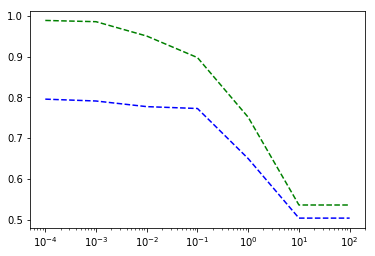

In [7]:
import matplotlib.pyplot as plt

tr = np.array([])
te = np.array([])
alpha = np.array([0.0001,0.001,0.01,0.1,1.0,10.0,100.0])


classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha=0.001, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha=0.01, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha=0.1, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha=1.0, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha=10.0, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha=100.0, average=True)
classifier.fit(X_train, Y_train)

tr = np.append(tr, accuracy_score(Y_train, classifier.predict(X_train)))
te = np.append(te, accuracy_score(Y_test, classifier.predict(X_test)))

print("\n\nAlpha versus Training Accuracy (Green) and Testing Accuracy (Blue)")
plt.semilogx(alpha, tr, 'g--', alpha, te, 'b--')
plt.show()



Tau vs. Test Precision with Training Data Classifier (Green) and Testing Data Classifier (Blue)


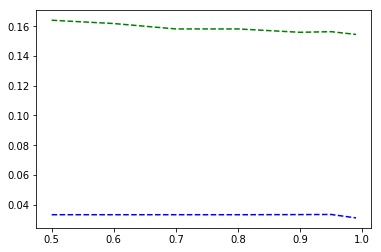



Tau vs. Test Precision with Testing Data Classifier Alone


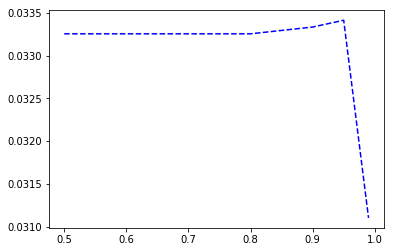

In [8]:
import matplotlib.pyplot as plt

# use this function for deliverable 3.5
#[0.5,0.6,0.7,0.8,0.9,0.95,0.99]
def threshold(probs, tau):
    return np.where(probs[:,0] > tau, 1, 0)

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_test, Y_test)

pr = np.array([])
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.5)))
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.6)))
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.7)))
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.8)))
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.9)))
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.95)))
pr = np.append(pr, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.99)))

classifier2 = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_train, Y_train)

pr2 = np.array([])
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.5)))
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.6)))
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.7)))
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.8)))
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.9)))
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.95)))
pr2 = np.append(pr2, precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.99)))

tau = np.array([0.5,0.6,0.7,0.8,0.9,0.95,0.99])

print("\n\nTau vs. Test Precision with Training Data Classifier (Green) and Testing Data Classifier (Blue)")
plt.plot(tau, pr2, 'g--', tau, pr, 'b--')
plt.show()

print("\n\nTau vs. Test Precision with Testing Data Classifier Alone")
plt.plot(tau, pr, 'b--')
plt.show()

In [9]:
classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_train, Y_train)

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
scores 

array([0.79847909, 0.77862595, 0.79310345, 0.79310345, 0.81992337])


Testing (Blue) and Training (Green) Accuracy of Linear kernel at various C


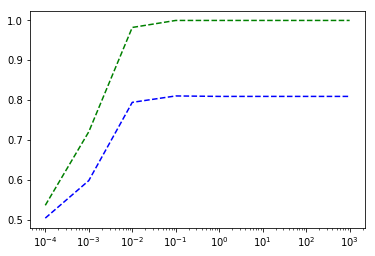


Testing (Blue) and Training (Green) Accuracy of Poly-2 kernel at various C


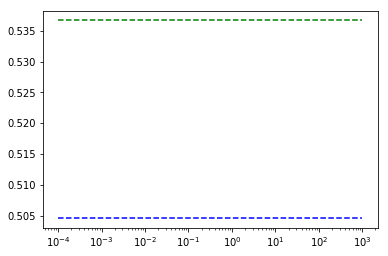


Testing (Blue) and Training (Green) Accuracy of Poly-3 kernel at various C


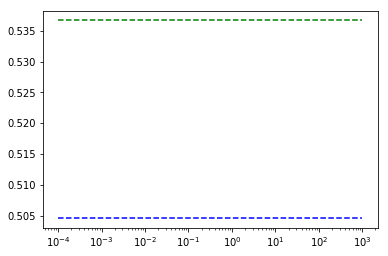


Testing (Blue) and Training (Green) Accuracy of RBF kernel at various C


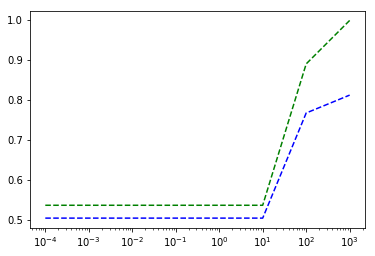

In [10]:
from sklearn.svm import SVC

clist = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.]

tr = np.array([])
te = np.array([])


for i in range(len(clist)):
    classifier = SVC(kernel='linear', C=clist[i], random_state=123)
    classifier.fit(X_train,Y_train)
        
    tr = np.append(tr,accuracy_score(Y_train, classifier.predict(X_train)))
    te = np.append(te,accuracy_score(Y_test, classifier.predict(X_test)))
    

print("\nTesting (Blue) and Training (Green) Accuracy of Linear kernel at various C")
plt.semilogx(clist, tr, 'g--', clist, te, 'b--')
plt.show()

tr = np.array([])
te = np.array([])

for i in range(len(clist)):
    classifier = SVC(kernel='poly', degree=2, C=clist[i], random_state=123)
    classifier.fit(X_train, Y_train)
    
    tr = np.append(tr,accuracy_score(Y_train, classifier.predict(X_train)))
    te = np.append(te,accuracy_score(Y_test, classifier.predict(X_test)))  
    
print("\nTesting (Blue) and Training (Green) Accuracy of Poly-2 kernel at various C")
plt.semilogx(clist, tr, 'g--', clist, te, 'b--')
plt.show()

tr = np.array([])
te = np.array([])

for i in range(len(clist)):
    classifier = SVC(kernel='poly', degree=3, C=clist[i], random_state=123)
    classifier.fit(X_train, Y_train)
    
    tr = np.append(tr,accuracy_score(Y_train, classifier.predict(X_train)))
    te = np.append(te,accuracy_score(Y_test, classifier.predict(X_test))) 
    
print("\nTesting (Blue) and Training (Green) Accuracy of Poly-3 kernel at various C")
plt.semilogx(clist, tr, 'g--', clist, te, 'b--')
plt.show()

tr = np.array([])
te = np.array([])

for i in range(len(clist)):
    classifier = SVC(kernel='rbf', C=clist[i], random_state=123)
    classifier.fit(X_train, Y_train)
    
    tr = np.append(tr,accuracy_score(Y_train, classifier.predict(X_train)))
    te = np.append(te,accuracy_score(Y_test, classifier.predict(X_test))) 
    
print("\nTesting (Blue) and Training (Green) Accuracy of RBF kernel at various C")
plt.semilogx(clist, tr, 'g--', clist, te, 'b--')
plt.show()

In [11]:
classifier = SVC(kernel='linear', C=10, random_state=123)
classifier.fit(X_train,Y_train)

print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

classifier = SVC(kernel='rbf', C=1000., random_state=123)
classifier.fit(X_train, Y_train)

print("\nTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

Test accuracy: 0.809633
[0.77186312 0.80152672 0.81226054 0.79693487 0.81992337]

Test accuracy: 0.811927
[0.7756654  0.8129771  0.80842912 0.79693487 0.85057471]


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = [3,8,10,14,100]
leafsamples = [1,5,10,15,20,50]

for i in range(len(depths)):
    for j in range(len(leafsamples)):
        classifier = DecisionTreeClassifier(max_depth=depths[i], min_samples_leaf=leafsamples[j], random_state=123)
        classifier.fit(X_train, Y_train)
        
        print("\n\nMax depth: %0.1f" % depths[i])
        print("Min Leaf Samples: %0.1f" % leafsamples[j])
        print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))



Max depth: 3.0
Min Leaf Samples: 1.0
Training accuracy: 0.743119
Test accuracy: 0.717890


Max depth: 3.0
Min Leaf Samples: 5.0
Training accuracy: 0.741590
Test accuracy: 0.719037


Max depth: 3.0
Min Leaf Samples: 10.0
Training accuracy: 0.740061
Test accuracy: 0.720183


Max depth: 3.0
Min Leaf Samples: 15.0
Training accuracy: 0.740061
Test accuracy: 0.720183


Max depth: 3.0
Min Leaf Samples: 20.0
Training accuracy: 0.740061
Test accuracy: 0.720183


Max depth: 3.0
Min Leaf Samples: 50.0
Training accuracy: 0.720948
Test accuracy: 0.700688


Max depth: 8.0
Min Leaf Samples: 1.0
Training accuracy: 0.857798
Test accuracy: 0.775229


Max depth: 8.0
Min Leaf Samples: 5.0
Training accuracy: 0.837156
Test accuracy: 0.767202


Max depth: 8.0
Min Leaf Samples: 10.0
Training accuracy: 0.824924
Test accuracy: 0.754587


Max depth: 8.0
Min Leaf Samples: 15.0
Training accuracy: 0.805046
Test accuracy: 0.769495


Max depth: 8.0
Min Leaf Samples: 20.0
Training accuracy: 0.799694
Test accuracy: 0

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

n_ests = [10, 50, 100, 300]

for i in range(len(n_ests)):
    classifier = RandomForestClassifier(n_estimators=n_ests[i], max_depth=8, min_samples_leaf=15, random_state=123)
    classifier.fit(X_train, Y_train)
    
    print("\n\nN_Estimators: %0.1f" % n_ests[i])
    print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))



N_Estimators: 10.0
Training accuracy: 0.627676
Test accuracy: 0.591743


N_Estimators: 50.0
Training accuracy: 0.564985
Test accuracy: 0.538991


N_Estimators: 100.0
Training accuracy: 0.548165
Test accuracy: 0.513761


N_Estimators: 300.0
Training accuracy: 0.558869
Test accuracy: 0.522936


In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

hl1 = [50,100,200,300]
hl2 = [20,50,100,200]

for i in range(len(hl1)):
    classifier = MLPClassifier(hidden_layer_sizes=(hl1[i]), random_state=123)
    classifier.fit(X_train, Y_train)

    print("Hidden Layer: %0.1f" % hl1[i])
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\n\n")
for i in range(len(hl1)):
    print("\n\n")
    for j in range(len(hl2)):
        classifier = MLPClassifier(hidden_layer_sizes=(hl1[i], hl2[j]), random_state=123)
        classifier.fit(X_train, Y_train)

        print("Hidden Layer 1: %0.1f" % hl1[i])
        print("Hidden Layer 2: %0.1f" % hl2[j])
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test))) 

Hidden Layer: 50.0
Test accuracy: 0.790138
Hidden Layer: 100.0
Test accuracy: 0.780963
Hidden Layer: 200.0
Test accuracy: 0.784404
Hidden Layer: 300.0
Test accuracy: 0.786697






Hidden Layer 1: 50.0
Hidden Layer 2: 20.0
Test accuracy: 0.800459
Hidden Layer 1: 50.0
Hidden Layer 2: 50.0
Test accuracy: 0.798165
Hidden Layer 1: 50.0
Hidden Layer 2: 100.0
Test accuracy: 0.791284
Hidden Layer 1: 50.0
Hidden Layer 2: 200.0
Test accuracy: 0.790138



Hidden Layer 1: 100.0
Hidden Layer 2: 20.0
Test accuracy: 0.797018
Hidden Layer 1: 100.0
Hidden Layer 2: 50.0
Test accuracy: 0.799312
Hidden Layer 1: 100.0
Hidden Layer 2: 100.0
Test accuracy: 0.788991
Hidden Layer 1: 100.0
Hidden Layer 2: 200.0
Test accuracy: 0.784404



Hidden Layer 1: 200.0
Hidden Layer 2: 20.0
Test accuracy: 0.799312
Hidden Layer 1: 200.0
Hidden Layer 2: 50.0
Test accuracy: 0.792431
Hidden Layer 1: 200.0
Hidden Layer 2: 100.0
Test accuracy: 0.793578
Hidden Layer 1: 200.0
Hidden Layer 2: 200.0
Test accuracy: 0.794725



Hidd

In [15]:
#arbitrary cutoff of 79.5% test accuracy - 
#these were different the second time but I just kept the ones that I did, there's still no performance improvement over logistic regression

classifier = MLPClassifier(hidden_layer_sizes=(200), random_state=123)
classifier.fit(X_train,Y_train)

print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

classifier = MLPClassifier(hidden_layer_sizes=(50,200), random_state=123)
classifier.fit(X_train, Y_train)

print("\nTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

classifier = MLPClassifier(hidden_layer_sizes=(100,20), random_state=123)
classifier.fit(X_train, Y_train)

print("\nTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

classifier = MLPClassifier(hidden_layer_sizes=(200,200), random_state=123)
classifier.fit(X_train, Y_train)

print("\nTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

classifier = MLPClassifier(hidden_layer_sizes=(300,100), random_state=123)
classifier.fit(X_train, Y_train)

print("\nTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

classifier = MLPClassifier(hidden_layer_sizes=(300,200), random_state=123)
classifier.fit(X_train, Y_train)

print("\nTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

scores = cross_val_score(classifier, X_train, Y_train, cv=5)
print(scores)

Test accuracy: 0.784404
[0.81749049 0.82442748 0.79693487 0.82375479 0.84291188]

Test accuracy: 0.790138
[0.81749049 0.82824427 0.80842912 0.81609195 0.82758621]

Test accuracy: 0.797018
[0.80988593 0.82824427 0.80076628 0.81992337 0.83908046]

Test accuracy: 0.794725
[0.82509506 0.81679389 0.81992337 0.81992337 0.82758621]

Test accuracy: 0.786697
[0.81749049 0.83587786 0.81609195 0.82375479 0.85057471]

Test accuracy: 0.793578
[0.82129278 0.83206107 0.80842912 0.82375479 0.8467433 ]
